# Анализ возраста клиентов супермаркета

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Задачи системы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта: построить модель, которая по фотографии определит приблизительный возраст человека на основе набора фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

Подгружаем все необходимые модули и библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set()

Загрузим метки для изображений и посмотрим на общую информацию:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим чуть поглубже:

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Получили следующие данные:
- минимальный возраст - 1 год, максимальный 100 лет;
- половина выборки - люди до 30, выборка имеет хвост справа (это будет видно на графике дальше);
- общее количество данных в выборке - 7591 изображений.

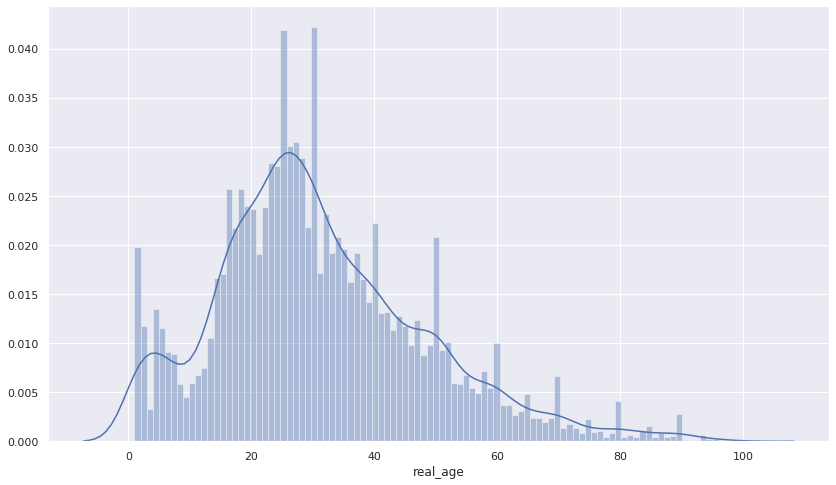

In [6]:
# построим распределение для исходных данных
fig, ax = plt.subplots(figsize=(14, 8))
sns.distplot(a=labels['real_age'], ax=ax, bins=100);

### Вывод:

Как видно из графика - в исходном датасете имеются много изображений детей в возрасте от 1 до 10 лет (пик в начале графика), а также имеется длинный хвост от 50 до 100 лет. Можно предположить, что нейросеть будет хорошо классифицировать людей до 60 лет, для классификации людей старше 60 может не хватить обучающих данных.

Теперь нужно создать загрузчик, загрузить изображения и разбить всю выборку на обучающую и валидационную.

In [7]:
# создаем загрузчик, определяем масштаб признаков
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

# создаем обучающий набор изображений
train_datagen_flow = datagen.flow_from_dataframe(
    directory='/datasets/faces/final_files/',
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

Found 6073 validated image filenames.


In [8]:
# создаем валидационный набор изображений
val_datagen_flow = datagen.flow_from_dataframe(
    directory='/datasets/faces/final_files/',
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 1518 validated image filenames.


Выборки разделены в пропорции 80/20.

Посмотрим на структуру датасета (например, обучающего):

In [9]:
features, target = next(train_datagen_flow)

In [10]:
# напишем функцию для вывода информации по признакам
def data_info(shape):
    print('Структура одного изображения в датасете:')
    print(f'Количество изображений в батче = {shape[0]}')
    print(f'Размер изображения = {shape[1]}x{shape[2]} пикселей')
    print(f'Количество каналов = {shape[3]}')

In [11]:
data_info(features.shape)

Структура одного изображения в датасете:
Количество изображений в батче = 32
Размер изображения = 224x224 пикселей
Количество каналов = 3


In [12]:
# посмотрим на целевой признак
target

array([39, 27, 41, 19, 14, 18, 23, 46, 69, 20, 46, 50, 58, 34, 25, 24, 24,
       25, 35, 41,  9, 31, 42, 25, 46, 37, 28, 31, 30, 29, 34, 46])

Напечатаем первые 15 фотографий:

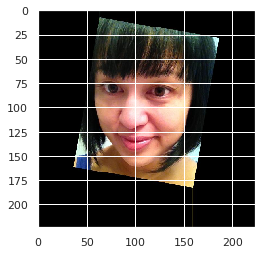

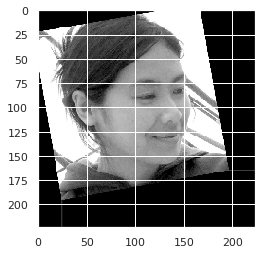

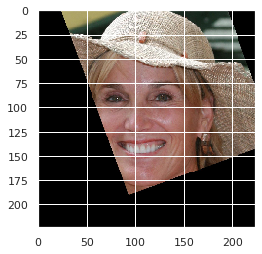

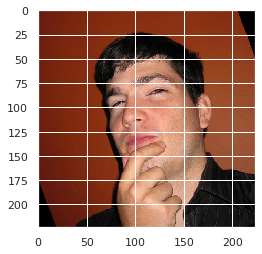

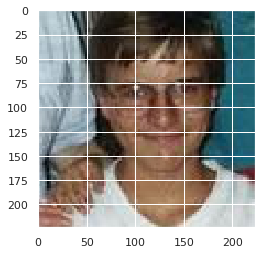

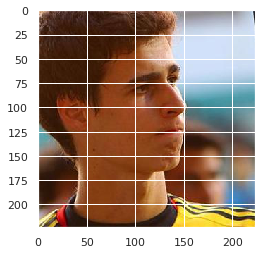

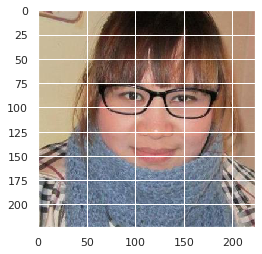

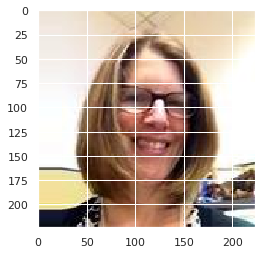

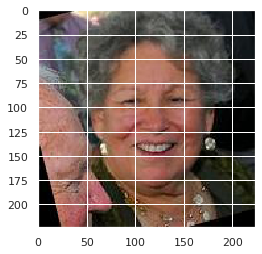

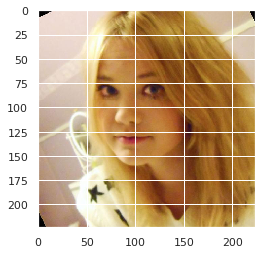

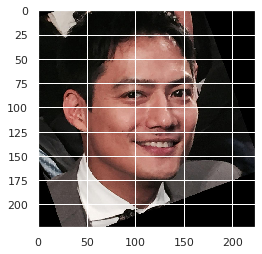

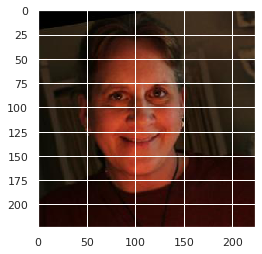

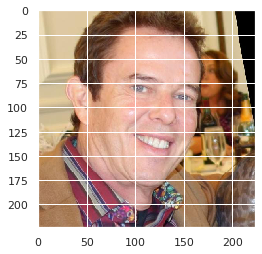

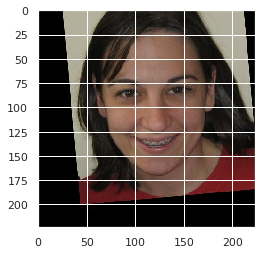

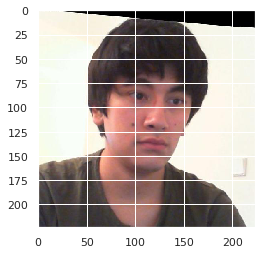

In [13]:
for i in range(15):
    plt.imshow(features[i])
    plt.show()

Фото подгружаются корректно, центр лиц размещен в центре сетки графика.

### Анализ фотографий:

1. В датасете есть как черно-белые, так и цветные фотографии. Для корректного обучения сети лучше привести фото к серой карте цветов (cmap='gray').
2. Некоторые фото достаточно старые и зашумлены - можно было бы попробовать повысить контрастность этих фото для более четкого выделения контуров разных частей распознаваемых объектов.
3. Также некоторые фото сделаны при плохом освещении. Возможно, можно было бы привести их (или все фото) к какому-нибудь определенному уровню экспозиции (если корректировать все фото, то для темных фото экспозицию повысить, для светлых - понизить).
4. На фотографиях различные размеры лиц, можно попробовать масштабировать фото для приведения к одному размеру лица (можно было бы использовать фильтрацию контуров и по ним масштабировать - помогла бы библиотека OpenCV).
5. Так как фото людей старше 60 достаточно мало, можно было бы выполнить геометрические аугментации(повороты, зеркальные отражения по различным осям и т.д.) для увеличения числа обучаемых объектов для лучшего распознавания людей старше 60.

# 2. Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке:

```python
# подгружаем необходимые библиотеки
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

# создаем загрузчик и подгружаем обучающие данные
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)

    train_data = train_datagen.flow_from_dataframe(
        directory=path+'final_files/',
        dataframe=pd.read_csv(path+'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_data

# создаем загрузчик и подгружаем тестовые данные
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)

    test_data = test_datagen.flow_from_dataframe(
        directory=path+'final_files/',
        dataframe=pd.read_csv(path+'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data

# настраиваем и подготавливаем модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

# обучаем сеть
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

После загрузки кода в тренажер был получен следующий вывод:

```
2020-07-05 12:18:44.380546: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-07-05 12:18:44.755451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2020-07-05 12:18:58.041412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-05 12:18:58.733806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-07-05 12:18:58.733899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-05 12:18:58.733945: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-05 12:18:59.000280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-07-05 12:18:59.131542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-07-05 12:18:59.816484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-07-05 12:18:59.918520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-07-05 12:18:59.918616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-07-05 12:18:59.922771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-07-05 12:18:59.923222: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-05 12:19:00.165131: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-07-05 12:19:00.168655: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45fb670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-05 12:19:00.168692: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-07-05 12:19:00.543502: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4681690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-07-05 12:19:00.543553: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-07-05 12:19:00.545639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-07-05 12:19:00.545741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-05 12:19:00.545758: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-05 12:19:00.545789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-07-05 12:19:00.545806: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-07-05 12:19:00.545822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-07-05 12:19:00.545837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-07-05 12:19:00.545849: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-07-05 12:19:00.549468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-07-05 12:19:00.555503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-05 12:19:06.701973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-07-05 12:19:06.702032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-07-05 12:19:06.702057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-07-05 12:19:06.734778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/8
2020-07-05 12:19:46.860256: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-05 12:19:50.818518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 115s - loss: 237.6341 - mean_absolute_error: 11.7532 - val_loss: 286.8043 - val_mean_absolute_error: 13.2138
Epoch 2/8
190/190 - 41s - loss: 150.4993 - mean_absolute_error: 9.4670 - val_loss: 462.1459 - val_mean_absolute_error: 16.2926
Epoch 3/8
190/190 - 41s - loss: 121.2080 - mean_absolute_error: 8.4605 - val_loss: 305.9548 - val_mean_absolute_error: 13.0462
Epoch 4/8
190/190 - 41s - loss: 91.0434 - mean_absolute_error: 7.3500 - val_loss: 240.2269 - val_mean_absolute_error: 12.2507
Epoch 5/8
190/190 - 40s - loss: 70.3289 - mean_absolute_error: 6.4857 - val_loss: 160.1730 - val_mean_absolute_error: 9.3409
Epoch 6/8
190/190 - 41s - loss: 50.3753 - mean_absolute_error: 5.5157 - val_loss: 118.7828 - val_mean_absolute_error: 8.3761
Epoch 7/8
190/190 - 42s - loss: 38.2530 - mean_absolute_error: 4.7840 - val_loss: 122.2804 - val_mean_absolute_error: 8.1942
Epoch 8/8
190/190 - 41s - loss: 28.4187 - mean_absolute_error: 4.1536 - val_loss: 108.7392 - val_mean_absolute_error: 7.8027
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 108.7392 - mean_absolute_error: 7.8027
Test MAE: 7.8027
```

# 3. Анализ обученной модели

Выводы по обучению можно сделать следующие:
- модель обучилась на архитектуре ResNet50;
- MAE модели равно 7.8027, что удовлетворяет условию MAE < 8, следовательно, модель будет определять возраст клиента магазина с погрешностью в 7-8 лет;
- модель обучилась на 8 эпохах (в одной эпохе 190 шагов обучения на обучающей и 48 на тестовой выборках), обучение по медиане составило примерно 41 секунду (в первой эпохе подгружались дополнительные библиотеки);
- для увеличения точности предсказания сети можно было предпринять следующие шаги:
  - выполнить рекомендации по аугментации, описанные в анализе изображений раздела 1;
  - увеличить количество эпох обучения;
  - уменьшить шаг обучения оптимизатора Adam.